In [2]:
import scipy
import numpy as np

import scipy.linalg as sla 
import numpy.linalg as la 
import matplotlib.pyplot as plt

from scipy.linalg import solve_continuous_are as CARE

# Make sure we can import required slycot routine
try:
    from slycot import sg02ad
except ImportError:
    raise print("Can't find slycot module 'sg02ad'")
from utils import *

In [3]:
def solve_care(A, B1, B2, Q, R, γ, S=None, E=None, stabilizing=True, method=None):
    """
        A Continuous-time (closed-loop) Riccati equation solver for two players 
        in a zero-sum linear quadratic differential game setting.

        Solve the equation 

            :math:`AP +A^T P - P (B_1 R^{-1} B_1^T - \gamma^{-2} B_2 B_2^T) P + Q = 0`

        where A and Q are square matrices of same dimension. In addition, Q is a symmetric 
        positive definite matrix. It returns the solution P, the gain matrices, K and L, as 
        well as the closed-loop eigenvalues of (A - B_1 K + B_2 L), where K and L are the 
        feedback gains of the two players given by 

            :math: `K=R^{-1}B_1^T P,      L = -\gamma^{-2} B_2^T P.`
        
        For details, see the IFAC paper by Lekan Molu and Hosein Hasanbeig.

        Parameters
        ----------
        A, B1, B2, Q : 2D arrays
            Input matrices for the Riccati equation.
        γ : The H infinity risk measure.
        R, S, E : 2D arrays, optional
            Input matrices for generalized Riccati equation.
        method : str, optional
            Set the method used for computing the result.  Current methods are
            'slycot' and 'scipy'.  If set to None (default), try 'slycot' first
            and then 'scipy'.

        Returns
        -------
        X : 2D array (or matrix)
            Solution to the Ricatti equation
        V : 1D array
            Closed loop eigenvalues
        K : 2D array (or matrix) for minimizing player
        L : 2D array (or matrix) for maximizing player
            Gain matrix

        Notes
        -----
        Author: Lekan Molu
        Date: October 19, 2022
    """

    assert method is not None, "method must be 'slycot' or 'scipy'"


    # Reshape input arrays
    A = np.array(A, ndmin=2)
    B1 = np.array(B1, ndmin=2)
    B2 = np.array(B2, ndmin=2)
    Q = np.array(Q, ndmin=2)
    R = np.eye(B1.shape[1]) if R is None else np.array(R, ndmin=2)
    if S is not None:
        S = np.array(S, ndmin=2)
    if E is not None:
        E = np.array(E, ndmin=2)

    # Determine main dimensions
    n = A.shape[0]
    m = B1.shape[1]


In [ ]:
def solve_ARE(A, B, D, Q, R, gamma):
    '''
    solve the indefinite Algebric Riccati Equation
    input:
        system model and weighting matrices
    output: 
        P: the optimal solution to ARE
        K: the optimal gain for control
        L: the optimal gain for disturbance
    '''
    
    dt = 0.0001
    xn = np.size(A,0)
    un = np.size(B,1)
    wn = np.size(D,1)
    P = np.zeros((xn,xn))
    P_pre = np.ones((xn,xn))
    
    step = 0
    
    while np.linalg.norm(P-P_pre)>1e-8 and step<1e8:
        step += 1
        P_pre = P;
        P = P_pre + (np.transpose(A)@P_pre + P_pre@A + Q \
            - P_pre@(B@np.linalg.pinv(R)@np.transpose(B) \
            - gamma**(-2)*D@np.transpose(D))@P_pre)*dt

    K = np.linalg.pinv(R)@np.transpose(B)@P
    L = gamma**(-2)*D.reshape((wn,xn))@P

    return P, K, L



In [ ]:
def system(dt, x, u):
    '''
    Discretized Linear Dynamics of the system dx = (Ax+Bu)dt + Ddw by E-M
    Input:
        dt: time step to 
        x: state of the system, 6 dim
        u: control input of the system, 2 dim
    Output:
        x_next: state at the next step
    '''
    A = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 1)
    A_ = np.array([[12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
                   [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
                   [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]])
    A = np.concatenate((A, A_), axis = 0)
    
    B = np.array([[-50.0, 6.12],
                  [174.4, -38.93],
                  [-124.2, 48.62]])
    B = np.concatenate((np.zeros((3,2)), B), axis = 0)
    
    D = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 0)
    
    xi = np.random.normal(0,1,3)
    x_next = x + (A@x+B@u)*dt + D@xi*np.sqrt(dt)
    
    return x_next


def int_system(dt, tf, x0, K, sigma):
    '''
    Intergrate the sde from 0 to tf
    Input:
        dt: time step to discrete the system
        tf: terminal time of the integral
        x0: initial state
        K: Controller
        sigma: magnitude of exploratory noise
    Output:
        X: state trajectory from 0 to tf
        U: input trajectory from 0 to tf
    '''
    N = int(tf/dt)
    X = np.zeros((N+1,6))
    U = np.zeros((N,2))
    X[0,:] = x0
      
    y = np.zeros(2)
    
    for i in range(N):
        t = i*dt
        y = y - y*dt + np.random.normal(0,1,2)*np.sqrt(dt)
        u = -K@X[i,:] + sigma*y
        x_next = system(dt, X[i,:], u)
        X[i+1,:] = x_next
        U[i,:] = u
        
    return X, U
        

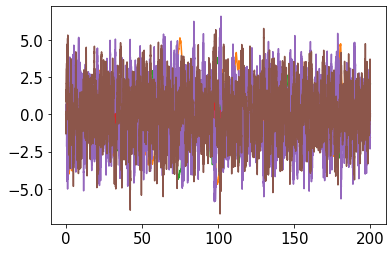

In [ ]:
# run system and collect the data
dt = 0.001
tf = 1500.0
sigma = 10
K_init = np.array([[-257.5,	-96.0,	-39.4,	-85.6,	-37.5,	-19.8],
[-628.4,	-236.7,	-94.1,	-208.6,	-93.3,	-46.7]]) 
# x0 = np.random.normal(0,1,6)
x0 = np.zeros(6)
T = np.arange(0., tf+dt, dt)
X, U = int_system(dt, tf, x0, K_init, sigma)

plt.plot(T, X)
plt.show()

In [ ]:
# Required data matrices for learning algorithm
xn = np.size(X,1) #state dim
un = np.size(U,1) #control dim
wn = 3 #disturbance dim
n_vecv = int((xn+1)*xn/2)
n_phi = n_vecv + xn*un + 1
n_data = len(U) # the total num of data

Phi = np.zeros((n_phi, n_phi))
Xi = np.zeros((n_phi, n_vecv))

for i in range(n_data):
    phi = np.concatenate((vecv(X[i]), 2*np.kron(X[i],U[i])), axis = 0)
    phi = np.concatenate((phi, np.ones(1)), axis = 0)
    Phi += np.outer(phi,phi)*dt
    Xi += np.outer(phi,(vecv(X[i+1])-vecv(X[i])))

Phi = Phi/tf
Xi = Xi/tf    
Phi_inv = np.linalg.pinv(Phi)
        

In [ ]:
A = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 1)
A_ = np.array([[12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
    [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
    [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]])
A = np.concatenate((A, A_), axis = 0)

B = np.array([[-50.0, 6.12],
    [174.4, -38.93],
    [-124.2, 48.62]])
B = np.concatenate((np.zeros((3,2)), B), axis = 0)


In [ ]:
# Learning-based algorithm
Q = 1*np.eye(xn)
R = np.eye(un)
I = 20 # number of iterations for outer Loop
J = 30 # number of iterations for inner Loop
gamma = 5

D = np.concatenate((np.zeros((3,3)), 1*np.eye(3)), axis = 0)

K = np.array([[-257.5,	-96.0,	-39.4,	-85.6,	-37.5,	-19.8],
[-628.4,	-236.7,	-94.1,	-208.6,	-93.3,	-46.7]])

T_v_vs, T_vs_v  = trans_vec_vecs(xn)
T_vt = Trans_vec(un,xn)

P_storage = np.zeros((I,xn,xn)) #store the P matrices at each iteration
K_storage = np.zeros((I,un,xn)) #store the K matrices

for i in range(I):
    L = np.zeros((wn, xn))
    for j in range(J):
        LD = np.kron(np.eye(xn), np.transpose(L)@np.transpose(D)) + np.kron(np.transpose(L)@np.transpose(D), np.eye(xn))
        LD = T_v_vs@LD@T_vs_v
        KI = T_v_vs@(np.kron(np.eye(xn), np.transpose(K)) + np.kron(np.transpose(K), np.eye(xn))@T_vt)
        Q_KL = Q + np.transpose(K)@R@K - gamma**2*np.transpose(L)@L

        Lambda = Phi_inv[0:n_vecv,:]@Xi - KI@Phi_inv[n_vecv:n_vecv+xn*un,:]@Xi + LD
        P_vecs = -np.linalg.pinv(Lambda)@vecs(Q_KL)
        P = vecs_inv(P_vecs)
        L = gamma**(-2)*np.transpose(D)@P
        
    BP = Phi_inv[n_vecv:n_vecv+xn*un,:]@Xi@P_vecs
    BP = BP.reshape((xn,un))
    K = np.linalg.pinv(R)@np.transpose(BP)

    P_storage[i] = P
    K_storage[i] = K



In [ ]:

#calculate the optimal value
P_opt, K_opt, L_opt = solve_ARE(A, B, D, Q, R, gamma)



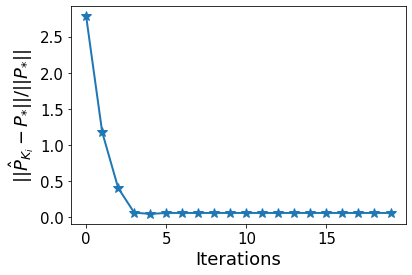

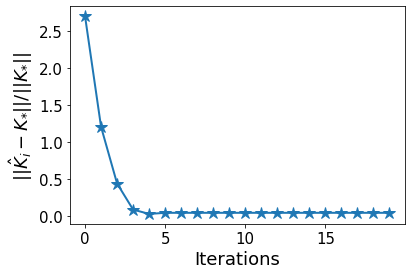

In [ ]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

P_norm = np.zeros(I)
K_norm = np.zeros(I)
for i in range(I):
    P_norm[i] = np.linalg.norm(P_storage[i]-P_opt)/np.linalg.norm(P_opt)
    K_norm[i] = np.linalg.norm(K_storage[i]-K_opt)/np.linalg.norm(K_opt)

It = np.linspace(start=0,stop=I,num=I,endpoint=False)
plt.plot(It, P_norm, '*-', linewidth=2.0, markersize=10)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('${||\hat{P}_{K_i}-P_{*}||}/{||P_{*}||}$', fontsize=18)
plt.show()

plt.plot(It, K_norm, '*-', linewidth=2.0, markersize=12)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('${||\hat{K}_{i}-K_{*}||}/{||K_{*}||}$', fontsize=18)
plt.show()

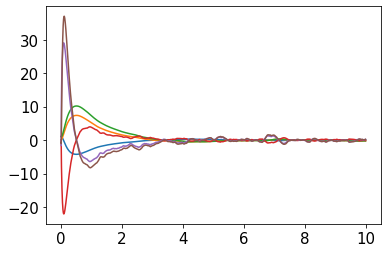

In [ ]:
# test the learned controller
sigma = 0.0
x0 = np.random.normal(0,1,6)
T = np.arange(0., 10.0+dt, dt)
X_test, U_test = int_system(dt, 10.0, x0, K, sigma)
plt.plot(T, X_test)
plt.show()

In [ ]:
print(np.linalg.eig(A-B@K))

print(K_opt)

(array([-228.52427626+0.j        ,  -20.35057374+0.j        ,
         -6.27225581+0.j        ,   -1.88905757+0.54105316j,
         -1.88905757-0.54105316j,   -1.01776696+0.j        ]), array([[-0.00095483+0.j        , -0.01919842+0.j        ,
         0.07145664+0.j        , -0.11989127-0.06841083j,
        -0.11989127+0.06841083j, -0.11010839+0.j        ],
       [ 0.00342452+0.j        ,  0.02026528+0.j        ,
        -0.08113884+0.j        ,  0.36568978+0.10473879j,
         0.36568978-0.10473879j,  0.4847811 +0.j        ],
       [-0.0025513 +0.j        ,  0.04036745+0.j        ,
        -0.11445084+0.j        ,  0.19797369+0.05254045j,
         0.19797369-0.05254045j, -0.49402313+0.j        ],
       [ 0.2182011 +0.j        ,  0.39069883+0.j        ,
        -0.44819432+0.j        ,  0.26349541+0.06436445j,
         0.26349541-0.06436445j,  0.11206468+0.j        ],
       [-0.78258526+0.j        , -0.41241012+0.j        ,
         0.50892356+0.j        , -0.7474783 +0.j        